Analyse des documents

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime


In [ ]:
plt.style.use('ggplot')
sns.set(style=whitegrid)

In [6]:
def analyze_directory(directory="./data", recursive=True):
    """
    Analyse un dossier et retourne les informations sur les fichiers qu'il contient.
    
    Args:
        directory (str): Chemin vers le dossier à analyser
        recursive (bool): Si True, explore les sous-dossiers récursivement
    
    Returns:
        pd.DataFrame: DataFrame contenant les informations sur les fichiers
    """
    # Chemin complet du dossier
    data_dir = Path(directory).resolve()
    print(f"Analyse du dossier: {data_dir}")

    files_info = []
    
    # Parcourir le dossier de manière récursive ou non
    if recursive:
        all_files = list(data_dir.glob('**/*'))
    else:
        all_files = list(data_dir.glob('*'))
    
    # Collecter les informations pour chaque fichier
    for file_path in all_files:
        if file_path.is_file():
            try:
                stats = file_path.stat()
                files_info.append({
                    'name': file_path.name,
                    'path': str(file_path),
                    'extension': file_path.suffix.lower(),
                    'size_bytes': stats.st_size,
                    'size_kb': stats.st_size / 1024,
                    'size_mb': stats.st_size / (1024 * 1024),
                    'modified': datetime.fromtimestamp(stats.st_mtime),
                    'created': datetime.fromtimestamp(stats.st_ctime),
                    'parent_folder': str(file_path.parent.relative_to(data_dir)) if file_path.parent != data_dir else '',
                })
            except Exception as e:
                print(f"Erreur pour {file_path}: {str(e)}")
    
    # Créer un DataFrame
    df = pd.DataFrame(files_info)
    
    return df

files_df = analyze_directory()
print(f"Analyse terminée. {len(files_df)} fichiers trouvés.")
files_df.head()


Analyse du dossier: E:\Dev\Synapsia\SpotiJob\coderome\data
Analyse terminée. 1158 fichiers trouvés.


,name,path,extension,size_bytes,size_kb,size_mb,modified,created,parent_folder
0,0006f5d8-6205-45c1-a814-b43e198e5a66_635624456...,E:\Dev\Synapsia\SpotiJob\coderome\data\0006f5d...,.pdf,536145,523.579102,0.511308,2025-03-30 12:06:12,2025-04-28 18:10:35.710554,
1,007662be-6fff-4c1b-a411-97afdfe1ebb6_635878576...,E:\Dev\Synapsia\SpotiJob\coderome\data\007662b...,.docm,56872,55.539062,0.054237,2025-03-30 12:03:18,2025-04-28 15:39:11.524173,
2,01ee0ca2-3cb0-4c40-8c13-9ad13a297d54_637286813...,E:\Dev\Synapsia\SpotiJob\coderome\data\01ee0ca...,.pdf,212664,207.679688,0.202812,2025-03-30 12:01:30,2025-04-28 18:10:08.808882,
3,020a7263-1079-4a5d-afa5-71af7b5db0d8_638126717...,E:\Dev\Synapsia\SpotiJob\coderome\data\020a726...,.pdf,99450,97.119141,0.094843,2025-03-30 11:59:56,2025-04-28 18:10:32.036879,
4,02527914-5bb8-4268-bb8d-ddb02727c51a_636310643...,E:\Dev\Synapsia\SpotiJob\coderome\data\0252791...,.pdf,135880,132.695312,0.129585,2025-03-30 12:01:00,2025-04-28 18:10:21.170005,


In [9]:
def get_extension_statistics(files_df):
    """
    Calcule les statistiques par type d'extension.
    
    Args:
        files_df (pd.DataFrame): DataFrame contenant les informations des fichiers
    
    Returns:
        pd.DataFrame: DataFrame avec les statistiques par extension
    """
    if files_df.empty:
        return pd.DataFrame()
    
    # Nettoyer et normaliser les extensions
    files_df['extension'] = files_df['extension'].str.lower()
    files_df.loc[files_df['extension'] == '', 'extension'] = 'sans extension'
    
    # Créer un DataFrame récapitulatif
    extensions_stats = pd.DataFrame({
        'count': files_df['extension'].value_counts(),
        'total_size_mb': files_df.groupby('extension')['size_mb'].sum(),
        'avg_size_kb': files_df.groupby('extension')['size_kb'].mean(),
        'min_size_kb': files_df.groupby('extension')['size_kb'].min(),
        'max_size_kb': files_df.groupby('extension')['size_kb'].max()
    }).sort_values('count', ascending=False)
    
    return extensions_stats

extensions_stats = get_extension_statistics(files_df)
print("Statistiques par extension calculées.")
extensions_stats.head(10)

Statistiques par extension calculées.


,count,total_size_mb,avg_size_kb,min_size_kb,max_size_kb
extension,,,,,
.pdf,850,288.492181,347.548227,9.335938,4259.707031
.docx,149,12.916092,88.765625,3.635742,1273.765625
.docm,139,14.558789,107.253239,29.711914,1853.448242
.png,7,3.620631,529.646624,76.157227,2524.669922
.zip,6,0.488221,83.323079,10.199219,222.427734
.ppt,3,1.387695,473.666667,357.000000,563.500000
.jpg,2,0.245741,125.819336,81.607422,170.031250
.tif,1,0.217792,223.018555,223.018555,223.018555
.xlsx,1,0.467508,478.728516,478.728516,478.728516


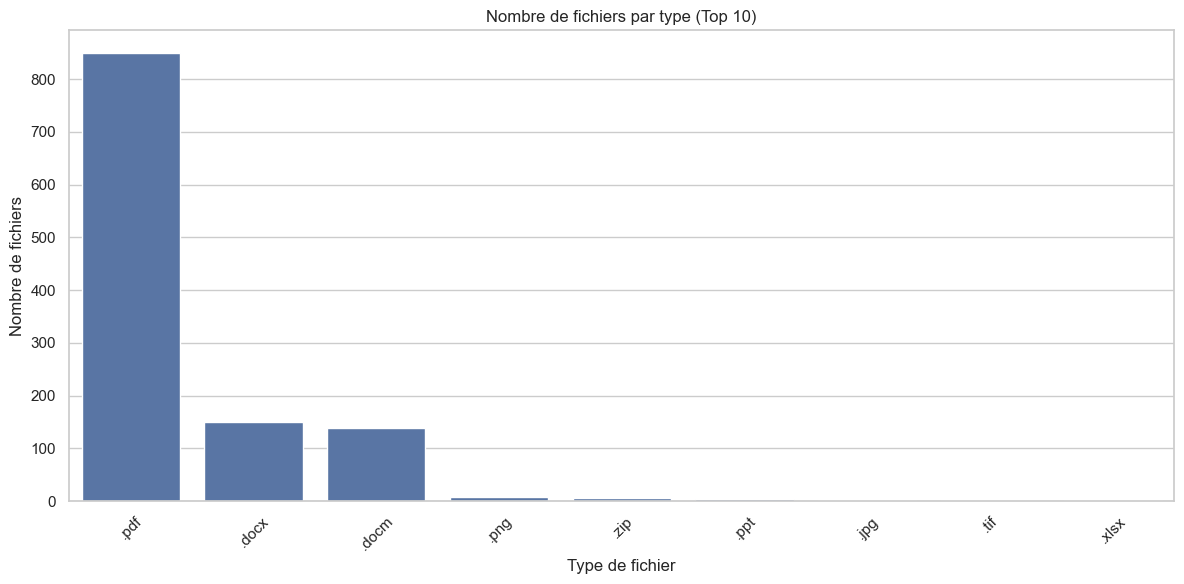

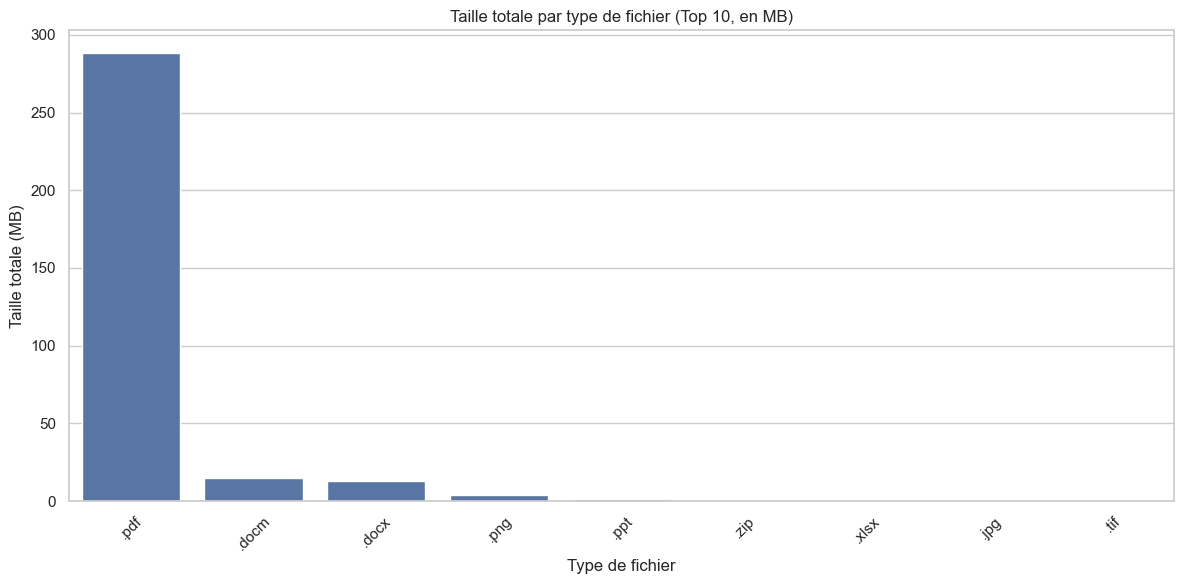

In [10]:
def plot_extensions_distribution(files_df, top_n=10):
    """
    Visualise la distribution des types de fichiers.
    
    Args:
        files_df (pd.DataFrame): DataFrame contenant les informations des fichiers
        top_n (int): Nombre d'extensions à afficher
    """
    if files_df.empty:
        print("Aucun fichier pour visualiser les distributions.")
        return
    
    extensions_count = files_df['extension'].value_counts().head(top_n)
    extensions_size = files_df.groupby('extension')['size_mb'].sum().sort_values(ascending=False).head(top_n)
    
    # Visualiser la distribution des types de fichiers
    plt.figure(figsize=(12, 6))
    sns.barplot(x=extensions_count.index, y=extensions_count.values)
    plt.title(f'Nombre de fichiers par type (Top {top_n})')
    plt.xlabel('Type de fichier')
    plt.ylabel('Nombre de fichiers')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Visualiser la taille totale par type
    plt.figure(figsize=(12, 6))
    sns.barplot(x=extensions_size.index, y=extensions_size.values)
    plt.title(f'Taille totale par type de fichier (Top {top_n}, en MB)')
    plt.xlabel('Type de fichier')
    plt.ylabel('Taille totale (MB)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_extensions_distribution(files_df, top_n=10)

In [11]:
def search_files(df, query, search_in=None):
    """
    Recherche des fichiers selon un critère.
    
    Args:
        df (pd.DataFrame): DataFrame contenant les informations des fichiers
        query (str): Terme de recherche
        search_in (list): Colonnes dans lesquelles chercher
        
    Returns:
        pd.DataFrame: Résultats de la recherche
    """
    if search_in is None:
        search_in = ['name', 'path', 'extension']
    
    result = pd.DataFrame()
    
    for column in search_in:
        if column in df.columns:
            # Recherche insensible à la casse
            matches = df[df[column].str.lower().str.contains(query.lower(), na=False)]
            result = pd.concat([result, matches])
    
    # Supprimer les doublons
    result = result.drop_duplicates()
    
    return result

In [ ]:
doc_files = search_files(files_df, "doc")


In [14]:
print(f"Nombre de fichiers correspondants : {len(doc_files)}")
display(doc_files[['name', 'extension', 'size_kb', 'modified']].head(10))


Nombre de fichiers correspondants : 296


,name,extension,size_kb,modified
1,007662be-6fff-4c1b-a411-97afdfe1ebb6_635878576...,.docm,55.539062,2025-03-30 12:03:18
6,02de0492-c7d5-4848-a62c-141e5a3d66db_635588308...,.docx,16.118164,2025-03-30 12:02:30
9,03765b2b-9266-4a3e-a104-daf4c132254c_636287349...,.docx,95.633789,2025-03-30 12:05:10
12,0413b19a-a3dd-4507-a6ce-32af440154ba_635878572...,.docm,56.932617,2025-03-30 12:00:20
15,04fb3e14-3adf-4b11-84c7-c68d5ce0aad0_638058495...,.docm,38.649414,2025-03-30 12:02:34
16,0583a289-4c3f-4454-b3a3-3d8058aaad48_635956403...,.docm,38.557617,2025-03-30 12:02:34
19,06b977df-70ee-49ef-8bc1-f55d09df3053_636180000...,.docm,90.824219,2025-03-30 12:02:40
21,078458dd-f73c-4027-835e-eb2d8c24fdee_638115511...,.pdf,2332.550781,2025-03-30 12:04:04
24,089d167a-1e67-4cdc-acbb-9768086c0327_636482532...,.docm,42.678711,2025-03-30 12:01:00
25,08a825fd-8d03-48bd-acbc-7549c8815df0_635049863...,.docm,38.292969,2025-03-30 12:05:24


In [15]:
docx_files_name_only = search_files(files_df, "docx", search_in=['name'])
print(f"\nFichiers avec 'docx' dans le nom : {len(docx_files_name_only)}")
display(docx_files_name_only[['name', 'extension', 'size_kb', 'modified']].head(10))


Fichiers avec 'docx' dans le nom : 149


,name,extension,size_kb,modified
6,02de0492-c7d5-4848-a62c-141e5a3d66db_635588308...,.docx,16.118164,2025-03-30 12:02:30
9,03765b2b-9266-4a3e-a104-daf4c132254c_636287349...,.docx,95.633789,2025-03-30 12:05:10
26,08e8ddc3-8779-4bf3-af33-b852f05e7ad6_638302822...,.docx,132.316406,2025-03-30 12:03:04
35,0aa691fb-fbba-4b5f-b28b-1d6d14220847_638294382...,.docx,76.495117,2025-03-30 12:00:54
43,0c69c844-595d-4e33-b01e-ace2afa247dd_638030678...,.docx,36.205078,2025-03-30 12:00:08
48,0d656dfd-b0a4-4b73-bfb8-4bea61c8919a_637377718...,.docx,41.698242,2025-03-30 12:03:38
49,0d7b5b23-3baa-43cb-baa2-766443fd2d8d_636286426...,.docx,44.912109,2025-03-30 12:01:10
50,0d8c451a-896c-4702-8197-418acd30dd18_635893352...,.docx,18.205078,2025-03-30 12:00:50
57,0fedcda1-088d-497d-9577-bce0875ee45c_636457462...,.docx,50.966797,2025-03-30 12:05:00
70,11df3422-6f5b-46ba-9d9d-3b2ce8755be3_635010267...,.docx,46.188477,2025-03-30 12:03:38


In [ ]:
pdf_large_files = search_files(files_df, "pdf")
pdf_large_files = pdf_large_files[pdf_large_files['size_mb'] > 1.0] 
print(f"\nFichiers PDF de plus d'1 MB : {len(pdf_large_files)}")
if not pdf_large_files.empty:
    display(pdf_large_files[['name', 'size_mb', 'modified']].sort_values('size_mb', ascending=False))


Fichiers PDF de plus d'1 MB : 43


,name,size_mb,modified
905,c833b24f-73c7-446b-9768-52093c958311_635291066...,4.159870,2025-03-30 12:01:58
971,d69b4cd4-3100-4572-9530-69fc5ca1c531_637877012...,3.506462,2025-03-30 12:04:10
1072,eb755c4b-cad5-411b-a937-6f7009867887_637454420...,3.110834,2025-03-30 12:01:40
190,2f753af9-aa33-4909-a91c-08fa938ff65a_635367832...,2.584292,2025-03-30 12:04:54
159,2a149b12-1eca-4113-bda9-a34a6d3c6c9b_636258641...,2.484489,2025-03-30 12:00:14
160,2a149b12-1eca-4113-bda9-a34a6d3c6c9b_636258641...,2.484489,2025-03-30 12:00:16
21,078458dd-f73c-4027-835e-eb2d8c24fdee_638115511...,2.277882,2025-03-30 12:04:04
72,126213c0-ede0-4024-98ff-0257d9175bfe_638404978...,2.228015,2025-03-30 12:03:04
693,99f151b2-5f15-4d31-bf85-65ddcf97c83e_635802559...,2.134450,2025-03-30 12:03:28
10,03939f7d-5cf9-4e34-a6c0-9e2b3a5d28eb_638182099...,1.895103,2025-03-30 12:03:54
